In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
red, blue = ['#FF0054', '#146EE8']

## Process

- Download index option data
- Only use OTM put and calls (more liquid)
- Estimate implied volatility $\sigma(K)$ for different strike prices $K$
- Interpolate $\sigma(K)$ for a dense set of strike prices $K$. Use fourth degree spline.
- Estimate corresponding BSM option prices from interpolated $\sigma(K)$
- Use Breeden-Litzenberger equation to estimate the Risk Neutral Density (RND) of underlying asset.
- Add tails using the Generalized Extreme Value (GEV) distribution.

**Data Sources**
- Option Metrics
- CRSP

In [4]:
df = pd.read_csv('options_data.csv', encoding = 'ISO-8859-1')

In [5]:
df.head(2)

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,div_convention,exercise_style,am_set_flag,option_price,K,days_to_expiration,spindx,S,r,q
0,108105,18/1/07,SPQ.NJ,0,17/2/07,20070117.0,P,1050000,0.0,0.25,...,I,E,1,0.125,1050,30,1426.37,1426.37,0.053728,0.019826
1,108105,18/1/07,SPQ.NO,0,17/2/07,NaN,P,1075000,0.0,0.25,...,I,E,1,0.125,1075,30,1426.37,1426.37,0.053728,0.019826


In [6]:
df = pd.read_csv('options_data.csv', encoding = 'ISO-8859-1')

## Keep only S&P500 options
df = df[df['ticker']=='SPX']

## Calculate mid-point price
df['option_price'] = (df['best_offer'] + df['best_bid'])/2

# Add formatted dates
df['exdate'] = pd.to_datetime(df.exdate)
df['date'] = pd.to_datetime(df.date)

# Keep only European
df = df[df['exercise_style']=='E']

# Get strike price
df['K'] = df['strike_price']/1000

# Keep only 30 day options
df['days_to_expiration'] = (df.exdate-df.date).dt.days
df = df[df['days_to_expiration']==30]

# Keep only OTM puts and calls
df = df[np.abs(df.delta)<=0.5]

df.shape

(4374, 41)

## Black-Scholes-Merton formula

$$
C(S,K,\tau,\sigma) = Se^{-q\tau}N(d1) - Ke^{-r\tau}N(d2)\\
P(S,K,\tau,\sigma) = Ke^{-r\tau}N(-d2) - Se^{-q\tau}N(-d1)\\
d_1 = \frac{ln\left(\frac{S}{Ke^{-r\tau}}\right) + \left(r - q + \frac{\sigma^2}{2}\right) \tau}{\sigma \sqrt{\tau}} \\
d_2 = d_1 - \sigma \sqrt{\tau}
$$




In [7]:
def call_price(S, K, tau, sigma, r, q):
    '''tau: days to expiration'''
    d1 = ( np.log(S*np.exp(-q*tau/365)/(K*np.exp(-r*tau/365))) + 
          (r - q + (sigma**2)/2)*tau/365 )/ (sigma * np.sqrt(tau/365))
    
    d2 = d1 - sigma* np.sqrt(tau/365)
    
    return (S*np.exp(-q*tau/365)*norm.cdf(d1) - K*np.exp(-r*tau/365)*norm.cdf(d2))

In [8]:
def put_price(S, K, tau, sigma, r, q):
    '''tau: days to expiration'''
    d1 = ( np.log(S/(K*np.exp(-r*tau/365))) + 
          (r - q + (sigma**2)/2)*tau/365 )/ (sigma * np.sqrt(tau/365))
    
    d2 = d1 - sigma* np.sqrt(tau/365)
    
    return (K*np.exp(-r*tau/365)*norm.cdf(-d2)- S*np.exp(-q*tau/365)*norm.cdf(-d1))

## BSM prices

In [9]:
# BSM call prices
dfc = df[df['cp_flag']=='C']
dfc['bsm_price'] = call_price(dfc['S'], dfc['K'],
                              dfc['days_to_expiration'], dfc['impl_volatility'],
                             dfc['r'], dfc['q'])

## Check BSM prices are closed to those reported
print(np.sqrt(np.sum((dfc['bsm_price'] - dfc['option_price'])**2)))
dfc[['bsm_price', 'option_price']].head(5)

23.058645437929744


,bsm_price,option_price
10,0.185272,0.150
11,0.186770,0.150
12,0.157529,0.125
13,0.127687,0.100
14,0.220908,0.175


In [10]:
# BSM put prices
dfp = df[df['cp_flag']=='P']
dfp['bsm_price'] = put_price(dfp['S'], dfp['K'],
                              dfp['days_to_expiration'], dfp['impl_volatility'],
                             dfp['r'], dfp['q'])

## Check BSM prices are closed to those reported
print(np.sqrt(np.sum((dfp['bsm_price'] - dfp['option_price'])**2)))
dfp[['bsm_price', 'option_price']].head(5)

33.51480833521834


,bsm_price,option_price
0,0.173390,0.125
1,0.172575,0.125
2,0.174830,0.125
3,0.201802,0.150
4,0.295140,0.225


In [11]:
df['bsm_price'] = np.where(df['cp_flag']=='C', call_price(df['S'], df['K'],
                              df['days_to_expiration'], df['impl_volatility'],
                             df['r'], df['q']),
                            put_price(df['S'], df['K'],
                              df['days_to_expiration'], df['impl_volatility'],
                             df['r'], df['q']))

## Interpolate Implied Volatilities

In [12]:
dates = df.date.value_counts().sort_index().index

In [13]:
def rnd(date):
    
    df_date = df[df['date']==date][['K', 'impl_volatility', 
                                 'S', 'cp_flag', 'symbol', 'option_price', 'bsm_price',
                                'days_to_expiration', 'r', 'q']]
    
    df_date = df_date.sort_values('K')
    df_date = df_date.drop_duplicates('K')
    
    from scipy.interpolate import UnivariateSpline
    x = df_date['K'].values
    y = df_date['impl_volatility'].values
    us = UnivariateSpline(x, y, k=4, s=len(x))

    xs = np.arange(x[0], x[-1], 0.1)
    ys = us(xs)

    df_int = pd.DataFrame({'K':xs, 'impl_volatility':ys})
    df_int['r'] = df_date['r'].mean()
    df_int['q'] = df_date['q'].mean()
    df_int['tau'] = df_date['days_to_expiration'].mean()
    df_int['S'] = df_date['S'].mean()
    df_int['cp_flag'] = np.where(df_int['K']<df_int['S'], 'P', 'C')

    df_int['bsm_price'] = call_price(df_int['S'], 
                        df_int['K'],
                        df_int['tau'], df_int['impl_volatility'],
                        df_int['r'], df_int['q'])
    
    # Estimate density
    df_int['l_bsm_price'] = df_int['bsm_price'].shift(1)
    df_int['f_bsm_price'] = df_int['bsm_price'].shift(-1)

    df_int['l_K'] = df_int['K'].shift(1)
    df_int['f_K'] = df_int['K'].shift(-1)

    df_int['density'] = np.exp(df_int['r']*df_int['tau'])*(df_int['f_bsm_price'] - 
         2*df_int['bsm_price'] + df_int['l_bsm_price'])/((df_int['f_K']
        -df_int['K'])*(df_int['K'] - df_int['l_K']))
    
    df_int = df_int[df_int['density'].isnull()==False]

    df_int['moneyness'] = round(df_int['K']/df_int['S'],2)
    df_int['f_density'] = df_int['density'].shift(-1)
    
    df_int['cumulative'] = np.exp(df_int['r']*df_int['tau'])*(df_int['f_bsm_price']-df_int[
        'l_bsm_price'])/(df_int['f_K'] - df_int['l_K']) + 1
    
    return df_int

In [14]:
from scipy.optimize import fsolve
from scipy.optimize import leastsq

def equations(p, *con):
    mu, sigma, eta = p
    s1, s2, s3, c1, c2, c3 = con
    return (np.exp(-(1+eta*((s1-mu)/sigma))**(-1/eta))-c1, 
            (np.exp(1+eta)**((-1/eta)-1))*np.exp(-(1+eta*((s2-mu)/sigma))**(-1/eta))-c2,
           (np.exp(1+eta)**((-1/eta)-1))*np.exp(-(1+eta*((s3-mu)/sigma))**(-1/eta))-c3)

def GEV(st, mu, sigma, eta):
    return (np.exp(1+eta)**((-1/eta)-1))*np.exp(-(1+eta*((st-mu)/sigma))**(-1/eta))

# October 2008

In [15]:
date = dates[23]
df_int = rnd(date)

In [16]:
date

Timestamp('2008-10-23 00:00:00')

In [17]:
df_int.head(2)

,K,impl_volatility,r,q,tau,S,cp_flag,bsm_price,l_bsm_price,f_bsm_price,l_K,f_K,density,moneyness,f_density,cumulative
1,300.1,1.481258,0.022273,0.020794,30.0,908.11,P,607.318414,607.417728,607.219101,300.0,300.2,0.000113,0.33,0.000113,-0.937310
2,300.2,1.481091,0.022273,0.020794,30.0,908.11,P,607.219101,607.318414,607.119789,300.1,300.3,0.000113,0.33,0.000113,-0.937298


In [18]:
## RIGHT-TAIL

# Set conditions to merge GEV distribution to RND.
# 1: probability of strike price lower than s1 equal to c1.
# 2: density at s2 equal to c2.
# 3: density at s3 equal to c3.

c1, s1 = 1-df_int.iloc[-2,:]['cumulative'], df_int.iloc[-2,:]['K']
c2, s2 = df_int.iloc[-2,:]['density'], df_int.iloc[-2,:]['K']
c3, s3 = df_int.iloc[-3,:]['density'], df_int.iloc[-3,:]['K']

con = (s1, s2, s3, c1, c2, c3)
con = [round(i,6) for i in con]
con = tuple(con)

init, n = leastsq(equations, (1, 1, 0.1), args=con)
mu, sigma, eta =  fsolve(equations, init, args=con)
right_tail = [GEV(i, mu, sigma, eta ) for i in np.arange(s1, 2000, 0.1)]

rt = pd.DataFrame({'K':np.arange(s1, 2000, 0.1),'density':right_tail})

In [19]:
## LEFT-TAIL

# Set conditions to merge GEV distribution to RND.
# 1: probability of strike price lower than s1 equal to c1.
# 2: density at s2 equal to c2.
# 3: density at s3 equal to c3.

c1, s1 = 1+df_int.iloc[1,:]['cumulative'], df_int.iloc[1,:]['K']
c2, s2 = df_int.iloc[1,:]['density'], df_int.iloc[1,:]['K']
c3, s3 = df_int.iloc[2,:]['density'], df_int.iloc[2,:]['K']

con = (s1, s2, s3, c1, c2, c3)
con = [round(i,6) for i in con]
con = tuple(con)

init, n = leastsq(equations, (0.5, 0.5, 0.5), args=con)
mu, sigma, eta =  fsolve(equations, init, args=con)
left_tail = [GEV(i, mu, sigma, eta ) for i in np.arange(0.1, s1, 0.1)]

lt = pd.DataFrame({'K':np.arange(0.1, s1, 0.1),'density':left_tail})

In [20]:
den = pd.concat([lt, df_int[['K', 'density']], rt])

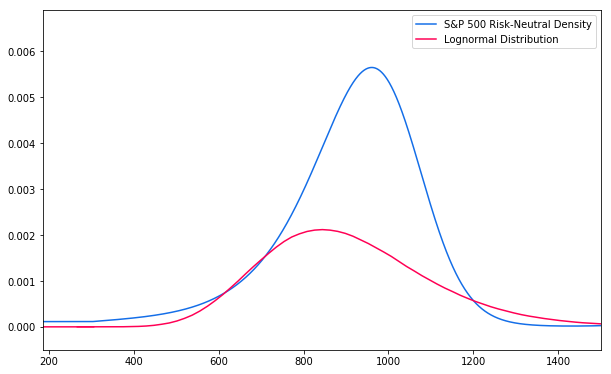

In [21]:
fig, ax = plt.subplots(figsize=(10,10/1.6))
ax.plot(den['K'], den['density'], label = 'S&P 500 Risk-Neutral Density', color=blue)

# Plot lognormal density for stock prices
r_mu = np.dot(den.K.values, den.density.values)/den.density.values.sum()
r_var = np.dot((den.K.values- r_mu)**2, den.density.values)/den.density.values.sum()

ln_r_mu = np.log(r_mu**2/(r_var + r_mu**2)**0.5)
ln_r_var = np.log(1+ (r_var/r_mu**2))

lognorm_prices = np.random.lognormal(ln_r_mu, np.sqrt(ln_r_var), 1000000)
sns.distplot(lognorm_prices, hist=False, ax=ax, label = 'Lognormal Distribution', color=red)


# Add lognormal tails
ln_lt = den[den['K']<=np.min(lognorm_prices)]['K'].values
ax.plot(ln_lt, [0 for i in ln_lt], color=red)

ln_rt = den[den['K']>=np.max(lognorm_prices)]['K'].values
ax.plot(ln_rt, [0 for i in ln_rt], color=red)


ax.set_xlim(185,1500)
ax.set_ylim(-0.0005,0.0069)

plt.subplots_adjust(left=None, bottom=None, right=None, top=0.88,
                wspace=None, hspace=None)

plt.show()